# MNIST - Tensor
## Matthew Johnson, Feb 13, 2019

- MSE & RELU
Acc: 0.84

- Softmax improved results rapidly

In [6]:
import os
import torch
import torchvision
from torchvision import transforms

root = './mnist'

if not os.path.exists(root):
    os.mkdir(root)
    
#########
# DATA
##########

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

# Training Data
training_data = torchvision.datasets.MNIST(root=root,
                                           train=True,
                                           transform=trans,
                                           download=True)
# Testing Data
testing_data = torchvision.datasets.MNIST(root=root,
                                          train=False,
                                          transform=trans,
                                          download=True)

# Data Loader
batch_size = 64

# Training data
training_loader = torch.utils.data.DataLoader(dataset=training_data,
                                              batch_size=batch_size,
                                              shuffle=True)
# Training data
testing_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                             batch_size=batch_size)

# Data Iterators
data_iter = iter(training_loader)
images, labels = next(data_iter)
print('images:', images.shape)
print('labels:', labels.shape)

images: torch.Size([64, 1, 28, 28])
labels: torch.Size([64])


In [30]:
import numpy as np

# One hot encoding function
def one_hot_encode(pre_labels, n_classes):
    labels = []

    for num in range(len(pre_labels)):
        # idx <- class: 0, 1, 2
        idx = pre_labels[num]
        # Array of Zeros
        arr = np.zeros(n_classes)
        # One hot encode array by class index
        arr[idx] = 1
        # Add array to labels (list)
        labels.append(arr)

    labels = np.array(labels, dtype=int)

    return labels

# SOFTMAX
def softmax(X):
    '''
    X: output of last fc layer, dim = [num_examples, num_classes]
    output: 
    '''
    exps = torch.exp(X - torch.max(X))
    return exps / exps.sum()

## Training

In [107]:
dtype = torch.float

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

'''
N: batch size; 
D_in: input dimension;
H_1, H_2: hidden dimensions; 
D_out: output dimension.
'''

N = 64
D_in = 28*28
H_1 = 500
H_2 = 200
D_out = 10

# Hyperparamters
learning_rate = 1e-6
num_steps = 5000

# Tracking losses
loss_list = []

def train():
    # Randomly initialize weights
    w1 = torch.randn(D_in, H_1, device=device, dtype=dtype)
    w2 = torch.randn(H_1, H_2, device=device, dtype=dtype)
    w3 = torch.randn(H_2, D_out, device=device, dtype=dtype)

    # Data Iter (fresh)
    data_iter = iter(training_loader)
    iter_per_epoch = len(training_loader) # 938

    for t in range(num_steps):

        # Reset the data_iter
        if (t + 1) % iter_per_epoch == 0:
            data_iter = iter(training_loader)

        # Grab images and labels
        images, labels = next(data_iter)
        x, labels = images.view(images.size(0), -1).to(device), labels.to(device)
        # One hot encode labels and convert to tensor 
        onehot = one_hot_encode(pre_labels=labels, n_classes=10)
        y = torch.as_tensor(torch.from_numpy(onehot), device=device, dtype=dtype)

        # Forward pass: compute predicted y
        h1 = x.mm(w1)
        h1_relu = h1.clamp(min=0)

        h2 = h1_relu.mm(w2)
        h2_relu = h2.clamp(min=0)

        h3 = h2_relu.mm(w3)

        y_pred = torch.stack([softmax(_) for _ in h3])

        # Compute and print loss
        loss = (y_pred - y).pow(2).sum().item()

        # Backprop to compute gradients of w1, w2, and w3 with respect to loss
        grad_y_pred = 2.0 * (y_pred - y)

        grad_softmax = y_pred * (1 - y_pred)

        grad_w3 = h2_relu.t().mm(grad_softmax)
        grad_h2_relu = grad_y_pred.mm(w3.t())
        grad_h2 = grad_h2_relu.clone()
        grad_h2[h2 < 0] = 0

        
        grad_w2 = h1_relu.t().mm(grad_h2)
        grad_h_relu = grad_h2.mm(w2.t())
        grad_h = grad_h_relu.clone()
        grad_h[h1 < 0] = 0
        grad_w1 = x.t().mm(grad_h)
        
        #print('h_relu', h_relu.shape)
        #print('gh2:', grad_h2.shape)
        #print('g3', grad_w3.shape)
        #print('w3', w3.shape)
        #print('g2', grad_w2.shape)
        #print('w2', w2.shape)
        #print('g1', grad_w1.shape)
        #print('w1', w1.shape)

        # Update weights using gradient descent
        w1 -= learning_rate * grad_w1
        w2 -= learning_rate * grad_w2
        w3 -= learning_rate * grad_w3


        if t < 10 or (t + 1) % 1000 == 0:
            print(f'Step [{t+1}/{num_steps}], Loss: {loss:.4}')
            
        loss_list.append(loss)

## Prediction

In [101]:
def test():
    
    correct = 0
    loss = 0
    total = 0

    test_iter = iter(testing_loader)

    images, labels = next(test_iter)

    for images, labels in test_iter:
        # predict

        # Grab images and labels
        x, labels = images.view(images.size(0), -1).to(device), labels.to(device)
        onehot = one_hot_encode(pre_labels=labels, n_classes=10)
        y = torch.as_tensor(torch.from_numpy(onehot), device=device, dtype=dtype)

        # Forward pass: compute predicted y
        h1 = x.mm(w1)
        h1_relu = h1.clamp(min=0)

        h2 = h1_relu.mm(w2)
        h2_relu = h2.clamp(min=0)

        h3 = h2_relu.mm(w3)

        y_pred = torch.stack([softmax(_) for _ in h3])

        correct += (labels == torch.max(y_pred, 1)[1]).sum().item()
        loss += (y_pred - y).pow(2).sum().item()
        total += len(labels)

    print(f'Acc: {correct/total:.2} Loss: {loss/total:.4}')

In [108]:
train()

Step [1/5000], Loss: 112.0
Step [2/5000], Loss: 122.0
Step [3/5000], Loss: 118.0
Step [4/5000], Loss: 118.0
Step [5/5000], Loss: 116.0
Step [6/5000], Loss: 110.0
Step [7/5000], Loss: 108.0
Step [8/5000], Loss: 107.8
Step [9/5000], Loss: 115.7
Step [10/5000], Loss: 103.9
Step [1000/5000], Loss: 32.0
Step [2000/5000], Loss: 20.02
Step [3000/5000], Loss: 32.0
Step [4000/5000], Loss: 14.0
Step [5000/5000], Loss: 40.0


In [109]:
test()

Acc: 0.84 Loss: 0.3201


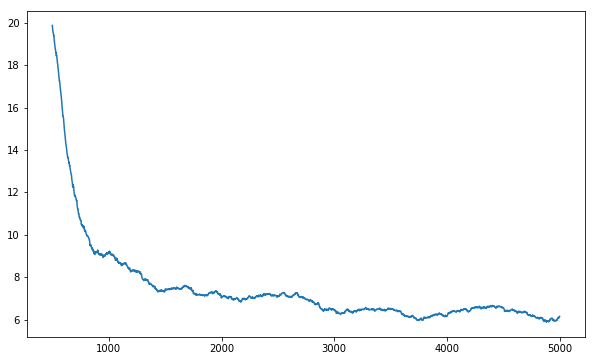

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

mavg_loss = pd.DataFrame({'loss': loss_list}).rolling(500).std()

plt.figure(figsize=(10, 6))
plt.plot(mavg_loss);